In [1]:
import pandas as pd
import boto3
import os
import pickle
import lightgbm as lgb
import numpy as np
from matplotlib import pyplot as plt

# 環境設定

In [2]:
BUCKET = "ryusuke-data-competition"
RESULT_PATH = os.path.join(f"s3://{BUCKET}", "results/")

# 分析

## 概要

In [49]:
df = pd.read_csv(os.path.join(RESULT_PATH, "summary.csv"))

In [50]:
df

,experiment_name,cv_score,MEMO,board_score
0,20240212_02,0.678057,20240205_01.pyのシードを変更．,NaN
1,20240212_02,0.575218,20240205_01.pyのシードを変更．,NaN
2,20240212_01,0.576007,20240202_04.pyのseedを変えた．optunaにもシードを設定．,NaN


## 詳細

In [43]:
df = pd.read_csv(os.path.join(RESULT_PATH, "20240212_02", "cv_details.csv"))
df["temp_sum"] = df["LightGBM"] + df["CatBoost"]
df["LightGBM"] = df["LightGBM"] / df["temp_sum"]
df["CatBoost"] = df["CatBoost"] / df["temp_sum"]
df = df.drop(columns="temp_sum")
df

,LightGBM,CatBoost,negative_ratio,cv_score
0,0.361989,0.638011,0.075668,0.670679
1,0.085053,0.914947,0.073849,0.675349
2,0.002054,0.997946,0.094972,0.681364
3,0.708552,0.291448,0.072169,0.675838
4,0.407562,0.592438,0.076132,0.687058


In [45]:
df.mean()

LightGBM          0.313042
CatBoost          0.686958
negative_ratio    0.078558
cv_score          0.678057
dtype: float64

### lightgbm

In [47]:
s3 = boto3.resource('s3')
lgb_model = pickle.loads(s3.Bucket(BUCKET).Object("results/20240212_02/20240212_02_LightGBM_model.pickle").get()['Body'].read())

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

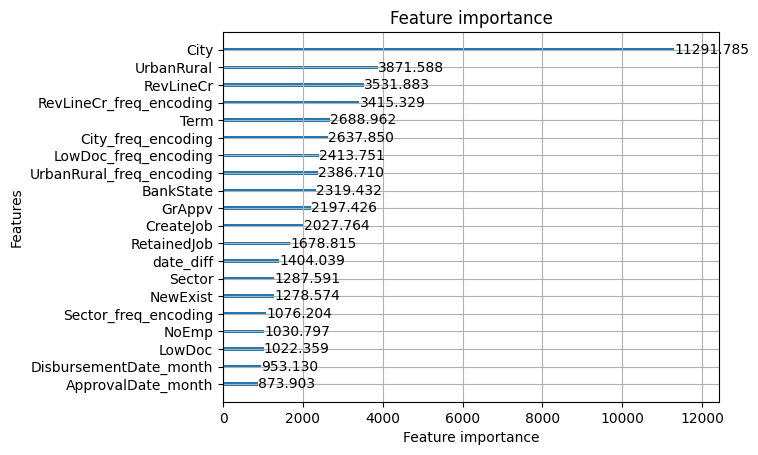

In [48]:
lgb.plot_importance(lgb_model, max_num_features=20, importance_type="gain")

In [31]:
lgb_model.params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'learning_rate': 0.05,
 'verbosity': -1,
 'random_seed': 42,
 'feature_fraction': 0.08077310865874585,
 'bagging_fraction': 0.05494362111207397,
 'num_leaves': 13,
 'lambda_l1': 0.7252596609901973,
 'lambda_l2': 0.9127595738672964,
 'num_iterations': 1000,
 'early_stopping_round': None,
 'categorical_column': [5, 6, 7, 8, 10, 11, 12, 16, 17]}

### catboost

In [32]:
s3 = boto3.resource('s3')
cb_model = pickle.loads(s3.Bucket(BUCKET).Object("results/20240205_03/CatBoost_model.pickle").get()['Body'].read())

Text(0.5, 1.0, 'Feature Importance')

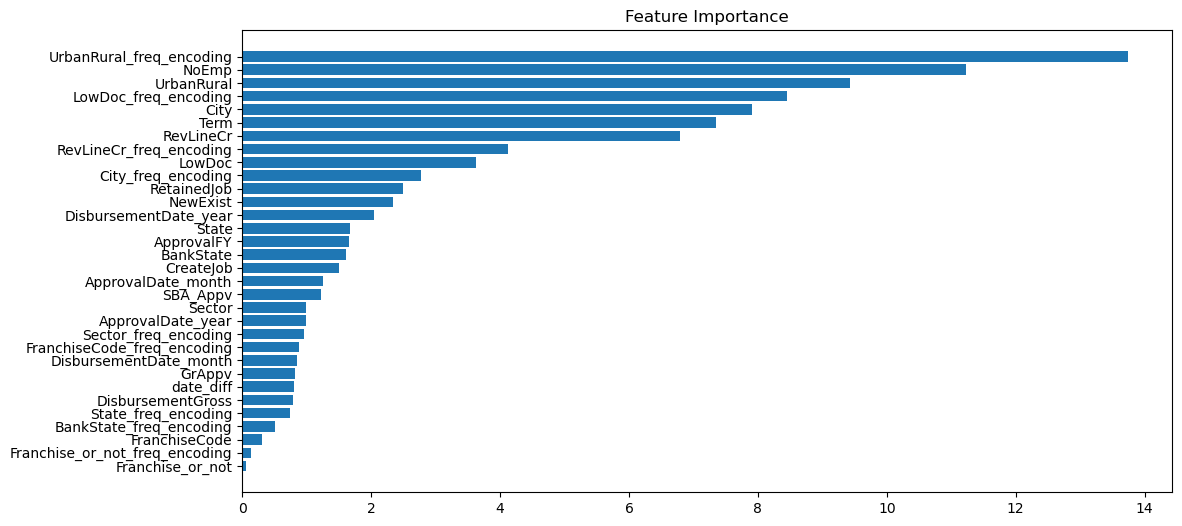

In [33]:
feature_importance = cb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cb_model.feature_names_)[sorted_idx])
plt.title('Feature Importance')

In [34]:
cb_model.get_params()

{'iterations': 1000,
 'learning_rate': 0.05,
 'depth': 2,
 'l2_leaf_reg': 0.3118099281811584,
 'random_seed': 42,
 'verbose': False,
 'subsample': 0.05840531264012393,
 'colsample_bylevel': 0.05584767124027292,
 'min_data_in_leaf': 5}

###  NN

In [3]:
s3 = boto3.resource('s3')
nn_model = pickle.loads(s3.Bucket(BUCKET).Object("results/20240205_03/NN_model.pickle").get()['Body'].read())

2024-02-07 21:07:39.638331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
nn_model.summary()

Model: "sequential_505"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_505 (Flatten)       (None, 452)               0         
                                                                 
 dense_3591 (Dense)          (None, 34)                15402     
                                                                 
 dropout_3086 (Dropout)      (None, 34)                0         
                                                                 
 dense_3592 (Dense)          (None, 1)                 35        
                                                                 
Total params: 15437 (60.30 KB)
Trainable params: 15437 (60.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
nn_model.get_layer("dropout_3086").rate

0.07707932119768192

In [18]:
dir(nn_model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_config',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_autotune_steps_per_execution',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',


In [25]:
nn_model.get_weights()

[array([[-0.04702794,  0.02195884, -0.00924196, ..., -0.02423963,
         -0.07997485,  0.03863598],
        [-0.07511726, -0.13316752,  0.12475041, ...,  0.00718049,
         -0.04397101,  0.0999709 ],
        [-0.02812981, -0.05440037, -0.11612002, ...,  0.07699434,
         -0.02551038, -0.06363056],
        ...,
        [-0.05952143, -0.10596232,  0.11898617, ..., -0.10099134,
         -0.04013019,  0.03720237],
        [ 0.01188075, -0.05012184,  0.14201109, ..., -0.11460222,
          0.13218965,  0.18722633],
        [ 0.03879857, -0.11082853,  0.054593  , ..., -0.00524517,
          0.08607601, -0.02091487]], dtype=float32),
 array([-0.03759215, -0.02122195,  0.07044722,  0.07549021, -0.01970612,
        -0.02585731, -0.03638621, -0.04359815, -0.03394724, -0.02163926,
         0.12288968,  0.12633607,  0.10136817, -0.03923422,  0.06289461,
         0.0756036 ,  0.06885456, -0.05165068, -0.04251888,  0.06992157,
         0.10096335, -0.02619335, -0.05641896,  0.08384953,  0.090